<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/Estudio_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planteamiento del Problema
El objetivo de este estudio es desarrollar y evaluar agentes de aprendizaje por refuerzo en el entorno **FrozenLake-v1 de Gymnasium**. En este entorno, el agente (representado por un personaje que debe cruzar un lago helado) debe aprender a:

* Navegar de manera segura por una cuadrícula de casillas resbaladizas.
* Evitar caer en agujeros que terminan el episodio prematuramente.
* Alcanzar el objetivo final (casilla de llegada) de manera eficiente.

Para ello, se implementan y comparan diferentes estrategias y algoritmos de aprendizaje por refuerzo, entre los que se incluyen:

* **Monte Carlo (On-Policy y Off-Policy)**: Métodos basados en la actualización de la función de valor utilizando episodios completos, aplicando distintas estrategias de exploración.
* **SARSA**: Un método que actualiza la función Q considerando la acción elegida en el siguiente estado, manteniendo una estrategia on-policy.
* **Q-Learning**: Un enfoque off-policy que actualiza los valores Q en función de la mejor acción posible en el siguiente estado.

El objetivo final es que, a través de la interacción con el entorno, el agente aprenda una política óptima que le permita maximizar la recompensa acumulada en cada episodio y llegar a la meta de forma segura y eficiente.

# Función de Recompensa en FrozenLake-v1
En este entorno, la función de recompensa está diseñada para fomentar un comportamiento eficiente y evitar caídas en los agujeros. Las recompensas se asignan de la siguiente manera:

* **Recompensa Positiva**:

 *  Se otorga una recompensa de +1 al llegar a la casilla objetivo con éxito.

* **Coste por Movimiento**:

  * Todos los movimientos intermedios tienen recompensa 0, lo que implica que el agente debe minimizar los pasos innecesarios para maximizar la probabilidad de éxito.
* **Penalización Indirecta**:

  * Si el agente cae en un agujero, el episodio termina sin recibir recompensa, lo que refuerza la necesidad de evitar estas casillas.

Dado que el entorno es estocástico (cuando es slippery=True, lo que simula el hielo resbaladizo), el agente debe aprender a manejar la incertidumbre y elegir estrategias que equilibren la exploración con la explotación para alcanzar la meta de manera consistente.

In [1]:
#@title Instalacion de librerias necesarias
!pip install gymnasium

# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,934 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,988 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mu

In [2]:
#@title Importación de librerias

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import re
import io
import base64
from IPython import display
from IPython.display import HTML
from pyvirtualdisplay import Display
from tqdm import tqdm

 Se define una  **Semilla** fija para garantizar que los resultados del entrenamiento sean reproducibles.

In [3]:
#@title Semilla
import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cpu


# Declaracion de entornos

In [4]:
#@title Importamos el entorno FrozenLake-v1
name = 'FrozenLake-v1'

# Creamos el entorno Taxi-v3
env = gym.make(name, render_mode="rgb_array")

#Funciones para representar las gráficas

La funcion *plot_episode_lengths:* se encarga de representar la evolución de la longitud de los episodios. Para ello, toma como entrada una lista o array de longitudes de episodios y, mediante una regresión lineal, calcula una línea de tendencia que se superpone a los datos originales. El gráfico resultante muestra en el eje X el número de episodio y en el eje Y la longitud del mismo, permitiendo visualizar tanto la variabilidad de cada episodio como la tendencia general a lo largo del entrenamiento.

In [5]:
#@title Funcion para mostrar los episodios
def plot_episode_lengths(episode_lengths, window_size=10):
    # Convertir a array por si acaso
    episode_lengths = np.array(episode_lengths)

    # Ajustar una regresión lineal a los datos
    x = np.arange(len(episode_lengths))
    coefficients = np.polyfit(x, episode_lengths, 1)  # Regresión lineal (grado 1)
    trend_line = np.polyval(coefficients, x)  # Calcular la línea de tendencia

    plt.figure(figsize=(8, 4))
    plt.plot(episode_lengths, label="Longitud del episodio", alpha=0.5)
    # Graficar la línea de tendencia en lugar de la media móvil
    plt.plot(x, trend_line, label="Línea de tendencia", color='red')
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.title("Evolución de la longitud de los episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

* Muestra la evolución de las recompensas obtenidas en cada episodio.
* Calcula y dibuja una línea de tendencia para visualizar si el agente mejora con el tiempo.
* Facilita la interpretación del rendimiento del agente en el entorno de entrenamiento

In [6]:
#@title Funciones de visualización de desempeño del agente durante el entrenamiento
import numpy as np
import matplotlib.pyplot as plt

def plot(list_stats, window_size=10):
    indices = list(range(len(list_stats)))

    # Convertir a array para asegurar el correcto manejo
    list_stats = np.array(list_stats)

    # Ajustar una regresión lineal a los datos
    x = np.arange(len(list_stats))
    coefficients = np.polyfit(x, list_stats, 1)  # Regresión lineal (grado 1)
    trend_line = np.polyval(coefficients, x)  # Calcular la línea de tendencia

    plt.figure(figsize=(8, 4))
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.5)
    plt.plot(x, trend_line, label="Línea de tendencia", color='red')  # Graficar la línea de tendencia
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    plt.legend()
    plt.show()

La **función plot_comparison()** compara visualmente el desempeño de dos enfoques de aprendizaje por refuerzo (On-Policy y Off-Policy) mostrando la evolución de las recompensas obtenidas a lo largo del entrenamiento.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(list_stats_on, list_stats_off, recompensas, window_size=10):
    # Convertir a arrays para garantizar el correcto manejo de datos
    list_stats_on = np.array(list_stats_on)
    list_stats_off = np.array(list_stats_off)

    indices_on = np.arange(len(list_stats_on))
    indices_off = np.arange(len(list_stats_off))

    plt.figure(figsize=(10, 5))

    # Graficar datos originales
    plt.plot(indices_on, list_stats_on, label="On-Policy (raw)", alpha=0.5)
    plt.plot(indices_off, list_stats_off, label="Off-Policy (raw)", alpha=0.5)

    # Configuración del gráfico
    plt.title("Comparación: On-Policy vs Off-Policy")
    plt.xlabel("Episodio")
    if recompensas is True:
      plt.ylabel("Proporción de recompensas")
    else:
      plt.ylabel("Longitud de los episodios")
    plt.legend()
    plt.grid(True)
    plt.show()

# Funciones para crear y reproducir los videos

La función *get_latest_episode_video_file* busca, dentro de un directorio especificado, el archivo de video que corresponde al episodio más reciente. Utiliza una expresión regular para identificar aquellos archivos que sigan el patrón "rl-video-episode-(número).mp4". Al recorrer los archivos del directorio, compara el número extraído de cada nombre y devuelve la ruta del archivo que tenga el mayor valor, asegurando así que se obtiene el video del episodio más actual.

La función *embed_video* se encarga de incrustar y reproducir un video directamente en el notebook. Para ello, abre el archivo de video en modo binario, lo codifica en formato base64 y luego utiliza un fragmento de HTML que contiene la etiqueta `<video>` para mostrarlo. Este método permite visualizar el video sin necesidad de utilizar reproductores externos, integrando la experiencia de reproducción de manera interactiva en el entorno del notebook.

In [8]:
def get_latest_episode_video_file(directory):
    """
    Devuelve el nombre (con ruta) del video .mp4 de episodio
    más reciente en 'directory', siguiendo el patrón
    'rl-video-episode-.mp4'.
    """
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)
    return latest_file

def embed_video(video_file):
    """
    Incrusta el video .mp4 en el notebook a partir de su ruta.
    """
    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data).decode()
    display.display(HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded_data}" type="video/mp4">
            Your browser does not support the video tag.
        </video>'''))


La función **record_policy_with_fn:** graba episodios completos ejecutando una política definida por el usuario. Inicialmente, crea la carpeta de destino para los videos (si aún no existe) y envuelve el entorno de Gym con el wrapper *RecordVideo*, el cual se encarga de capturar cada frame durante la ejecución del episodio. A continuación, por cada episodio, la función reinicia el entorno, ejecuta la política para seleccionar acciones y renderiza cada frame para que el proceso de grabación se lleve a cabo. Finalmente, retorna la ruta del directorio donde se almacenan los videos, facilitando el acceso y posterior reproducción de los episodios grabados.

In [9]:
def record_policy_with_fn(policy_fn, env=env, num_episodes=3, video_dir="videos"):
    """
    Graba episodios usando la función de política 'policy_fn' para seleccionar acciones.
    """
    import os, gym
    os.makedirs(video_dir, exist_ok=True)
    env = gym.wrappers.RecordVideo(env, video_folder=video_dir)

    for _ in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        while not done:
            action = policy_fn(state)
            # Handle different Gymnasium versions
            step_result = env.step(action)
            if len(step_result) == 4:  # For older versions
                state, _, done, _ = step_result
            else:  # For Gymnasium 0.26+
                state, _, terminated, truncated, _ = step_result
                done = terminated or truncated
            env.render()  # Necesario para capturar cada frame
    env.close()
    return video_dir

# Aplico Politica Greedy

La función **optimal_policy_from_q** utiliza la tabla Q para derivar la política óptima. Comienza en el estado inicial y, en cada paso, selecciona la acción con mayor valor (estrategia greedy), registrando las acciones y capturando cada frame renderizado. De esta manera, permite evaluar visualmente el comportamiento del agente al seguir la política óptima derivada de la tabla Q.

In [10]:
def optimal_policy_from_q(env, q_table, seed=None):
    """
    Ejecuta el entorno utilizando una política GREEDY a partir de q_table.

    Devuelve:
    - optimal_policy: Matriz que representa la acción óptima elegida en cada estado.
    - action_log: Cadena con el registro de las acciones tomadas.
    - frames_list: Lista de frames capturados durante la ejecución.
    """
    import numpy as np

    frames_list = []
    done = False
    optimal_policy = np.zeros([env.observation_space.n, env.action_space.n])
    initial_state, info = env.reset(seed=seed)  # Arranca en el estado inicial
    frame = env.render()
    frames_list.append(frame)
    action_log = ""

    current_state = initial_state
    while not done:
        # Obtener los valores Q para el estado actual y seleccionar la mejor acción
        q_values = q_table[current_state]
        best_action = np.argmax(q_values)

        # Registrar la acción
        action_log += f"{best_action}, "
        optimal_policy[current_state, best_action] = best_action

        # Ejecutar la acción en el entorno
        current_state, reward, terminated, truncated, info = env.step(best_action)
        frame = env.render()
        frames_list.append(frame)
        done = terminated or truncated

    return optimal_policy, action_log, frames_list

# **Monte Carlo**

La funcion **evaluate_policy** se utiliza para evaluar la política derivada a partir de Monte Carlo. Inicia reiniciando el entorno y captura el primer frame renderizado; luego, en cada iteración, selecciona la acción óptima consultando el vector de política (optimal_policy_vector) para el estado actual. A medida que el agente ejecuta las acciones en el entorno, se registra cada acción y se acumulan los frames renderizados hasta alcanzar un estado terminal. Finalmente, la función devuelve el registro de acciones y la secuencia de frames, permitiendo analizar la efectividad de la política aplicada.

In [11]:
#@title Funcion para la evaluación de la politica de Monte Carlo
def evaluate_policy(env, optimal_policy_vector, seed=None):
    state, info = env.reset(seed=seed)
    done = False
    action_log = []
    frames = []

    # Guardamos el primer frame
    frames.append(env.render())

    while not done:
        # Seleccionamos la acción óptima para el estado actual
        action = optimal_policy_vector[state]
        action_log.append(action)

        # Ejecutamos la acción en el entorno
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())

        done = terminated or truncated

    return action_log, frames

La funcion *optimal_policy_fn* actúa como un envoltorio simple para la política óptima calculada. Recibe un estado como entrada y devuelve directamente la acción correspondiente, según lo establecido en el vector de política óptima (optimal_policy_vector). Su simplicidad facilita la integración en otros procesos, como la grabación de episodios o la evaluación de la política, ya que encapsula la lógica de selección de acción en una única línea.

In [12]:
#@title Funcion para obtener la acción óptima para un estado dado
def optimal_policy_fn(state):
    return optimal_policy_vector[state]

## On policy

*Este método evalúa y mejora la política que se utiliza para generar episodios.* Durante la ejecución, se generan episodios completos utilizando la política actual, y se calcula el retorno acumulado para cada par estado-acción con el método every-visit (todas las visitas). A partir de estos retornos, se actualiza la función de valor Q a través de promedios, de manera que la política se refina iterativamente basándose en la experiencia directa obtenida con ella, garantizando la coherencia entre la evaluación y la generación de datos.

In [13]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env_mc_on = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_mc_on = gym.wrappers.RecordVideo(env_mc_on, video_folder="videos_mc_on")

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99       # Factor de descuento
EPSILON = 1.0      # Probabilidad de exploración
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.01

# Clase MonteCarloOnPolicyAgent
class MonteCarloOnPolicy:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializamos Q y el contador de visitas para cada par (estado, acción)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.N = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo On-Policy
    def update(self, episode):
        G = 0  # Retorno total

        # Recorrer el episodio en reversa
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            # Incrementar el contador para este par (state, action)
            self.N[state, action] += 1
            #self.Q[state, action] += (G - self.Q[state, action]) / (t + 1)  # Promedio incremental
            self.Q[state, action] += (G - self.Q[state, action]) / self.N[state, action]

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

*Iniciamos el agente y entrenamos al agente*

In [14]:
# Inicializar el agente
agent = MonteCarloOnPolicy(
    env=env_mc_on,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_mc_on = []
episodes_sizes_mc_on = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_mc_on.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_mc_on.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_mc_on.append(episode_reward)
    episodes_sizes_mc_on.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 10%|█         | 2048/20000 [00:05<00:43, 412.97it/s]

Éxito promedio: 0.0165, Épsilon: 0.8186406930090225


 20%|██        | 4001/20000 [00:07<00:15, 1042.63it/s]

Éxito promedio: 0.03375, Épsilon: 0.6702396082111141


 31%|███       | 6204/20000 [00:08<00:07, 1930.32it/s]

Éxito promedio: 0.05383333333333333, Épsilon: 0.548740291377179


 41%|████      | 8201/20000 [00:09<00:05, 2207.79it/s]

Éxito promedio: 0.069, Épsilon: 0.4492660590208893


 50%|█████     | 10073/20000 [00:10<00:06, 1476.87it/s]

Éxito promedio: 0.0829, Épsilon: 0.3678242603283259


 62%|██████▏   | 12401/20000 [00:11<00:03, 2117.94it/s]

Éxito promedio: 0.10308333333333333, Épsilon: 0.3011460219829101


 72%|███████▏  | 14366/20000 [00:12<00:01, 2869.73it/s]

Éxito promedio: 0.143, Épsilon: 0.24655504363736244


 82%|████████▏ | 16494/20000 [00:13<00:01, 3178.67it/s]

Éxito promedio: 0.18725, Épsilon: 0.20186017780594118


 93%|█████████▎| 18619/20000 [00:13<00:00, 3161.96it/s]

Éxito promedio: 0.22933333333333333, Épsilon: 0.16526748259824006


100%|██████████| 20000/20000 [00:14<00:00, 1393.16it/s]


La siguiente gráfica representa un aprendizaje estable, a pesar de que la proporción de recompensas parece alcanzar rápidamente el valor máximo (1.0), lo que sugiere que el agente puede estar explotando una estrategia óptima muy temprano, esté consigue realizar una exploración adecuada ( llegando al objetivo). El aprendizaje basado en episodios completos en un entorno que permite consolidar estrategias efectivas. La linea de tendencia es creciente lo que significa que las recompensas acumuladas crecen con el tiempo.

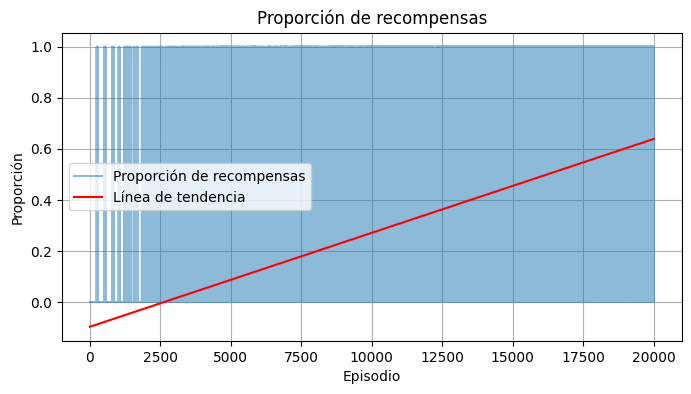

In [15]:
plot(rewards_per_episode_mc_on)

Al inicio, hay una gran varianza en la duración de los episodios, lo que indica que el agente está explorando distintas rutas y estrategias sin un patrón claro.
A medida que avanza el entrenamiento, se observa una ligera disminución en la longitud promedio de los episodios, aunque con bastante dispersión.
Esto sugiere que el agente está aprendiendo a llegar a su objetivo en menos pasos, pero aún hay episodios en los que puede tomar rutas más largas debido a exploración o decisiones subóptimas.
La línea de tendencia plana indica que la mejora en eficiencia es muy gradual o limitada, lo que podría indicar que la política aprendida aún no es completamente óptima.

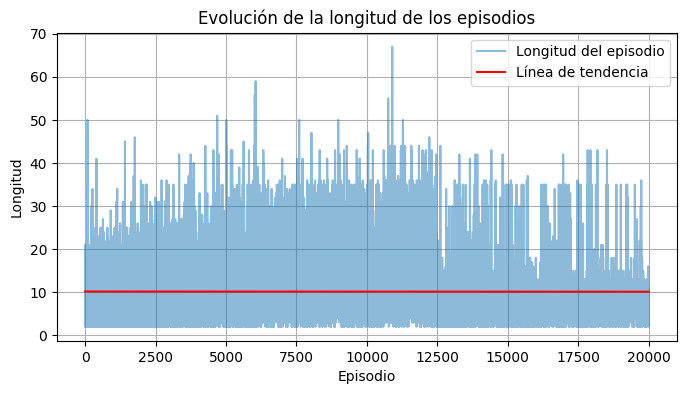

In [16]:
plot_episode_lengths(episodes_sizes_mc_on)

In [17]:
# Extraer la política óptima para todos los estados
optimal_policy_vector = np.argmax(agent.Q, axis=1)
print("Política óptima (vector de acciones):\n", optimal_policy_vector)

# Evaluar la política en un episodio de prueba
action_log, frames_recorded = evaluate_policy(env_mc_on, optimal_policy_vector, seed=seed)
print("\nAcciones tomadas en la evaluación:\n", action_log)
print("\nGrid del entorno:\n", env_mc_on.render())


Política óptima (vector de acciones):
 [2 3 0 0 2 0 0 0 3 2 2 0 0 2 2 0]

Acciones tomadas en la evaluación:
 [2, 2, 3, 3, 3, 2, 2, 2, 2, 2]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


Mostramos el video del estudio:

In [18]:
video_dir = record_policy_with_fn(optimal_policy_fn, env=env_mc_on, video_dir="videos_mc_on")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_mc_on folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_mc_on/rl-video-episode-20000.mp4


## OFF policy

En contraste, el método Off-Policy permite evaluar y mejorar una política objetivo utilizando datos generados por una política de comportamiento distinta. La diferencia entre ambas políticas se corrige aplicando técnicas de muestreo por importancia, que ponderan los retornos de cada par estado-acción según la probabilidad relativa de tomar la acción bajo la política objetivo versus la política de comportamiento. Esto posibilita la evaluación y mejora de la política objetivo sin necesidad de que ésta sea la que gobierne la generación de episodios, facilitando el aprendizaje y la optimización en escenarios donde explorar la política objetivo directamente resulta impráctico o ineficiente.

Definimos el agente:

In [19]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env_mc_off = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_mc_off = gym.wrappers.RecordVideo(env_mc_off, video_folder="videos_mc_off")

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99       # Factor de descuento
EPSILON = 1.0      # Probabilidad de exploración
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.002

# Clase MonteCarloOffPolicyAgent
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializamos Q y la suma de pesos acumulados C para cada par (estado, acción)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: acción greedy según Q

    # Actualizar la tabla Q usando Monte Carlo Off-Policy con muestreo por importancia ponderado
    def update(self, episode):
        G = 0  # Retorno acumulado
        W = 1  # Peso acumulado de importance sampling
        n_actions = self.env.action_space.n  # Número de acciones

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # Acumular el peso para el par (state, action)
            self.C[state, action] += W
            # Actualización incremental de Q(s,a) con la suma acumulada de pesos
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])

            # Si la acción tomada no es la acción greedy según la política target, terminamos la actualización
            if action != np.argmax(self.Q[state]):
                break

            # Calcular la probabilidad de tomar la acción greedy bajo la política comportamiento
            b_prob = (1 - self.epsilon) + (self.epsilon / n_actions)
            # Actualizar el peso W usando la relación de importancia
            W = W * (1.0 / b_prob)

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)


Inicializamos el agente y lo entrenamos:

In [20]:
# Inicializar el agente
agent = MonteCarloOffPolicyAgent(
    env=env_mc_off,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_mc_off = []
episodes_sizes_mc_off = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_mc_off.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_mc_off.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_mc_off.append(episode_reward)
    episodes_sizes_mc_off.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

# Cerrar el entorno
env_mc_off.close()

 12%|█▏        | 2365/20000 [00:01<00:07, 2278.61it/s]

Éxito promedio: 0.0145, Épsilon: 0.8186406930090225


 22%|██▏       | 4327/20000 [00:02<00:06, 2330.13it/s]

Éxito promedio: 0.02525, Épsilon: 0.6702396082111141


 32%|███▏      | 6434/20000 [00:03<00:05, 2640.17it/s]

Éxito promedio: 0.0305, Épsilon: 0.548740291377179


 41%|████      | 8167/20000 [00:04<00:05, 2154.74it/s]

Éxito promedio: 0.041875, Épsilon: 0.4492660590208893


 52%|█████▏    | 10311/20000 [00:05<00:04, 2310.18it/s]

Éxito promedio: 0.0612, Épsilon: 0.3678242603283259


 61%|██████    | 12222/20000 [00:05<00:03, 2110.02it/s]

Éxito promedio: 0.0855, Épsilon: 0.3011460219829101


 71%|███████   | 14190/20000 [00:06<00:02, 2043.26it/s]

Éxito promedio: 0.11685714285714285, Épsilon: 0.24655504363736244


 81%|████████  | 16201/20000 [00:07<00:01, 2363.64it/s]

Éxito promedio: 0.1486875, Épsilon: 0.20186017780594118


 92%|█████████▏| 18408/20000 [00:08<00:00, 2459.41it/s]

Éxito promedio: 0.18233333333333332, Épsilon: 0.16526748259824006


100%|██████████| 20000/20000 [00:09<00:00, 2180.35it/s]


En la siguiente gráfica (proporción de recompensas) el método Monte Carlo Off-Policy está logrando que el agente aprenda a resolver FrozenLake-v1 de manera efectiva, aunque el proceso de convergencia es gradual.
En los primeros episodios, la proporción de recompensas es muy baja, lo que indica que el agente aún no ha aprendido a alcanzar el objetivo de manera consistente.
Se observa una **gran variabilidad al inicio**, con episodios en los que ocasionalmente se obtienen recompensas.
A medida que avanza el entrenamiento, **la proporción de recompensas aumenta progresivamente**, lo que indica que el agente está mejorando su capacidad para alcanzar el objetivo.
La **línea de tendencia roja indica un crecimiento sostenido**, lo que significa que la política off-policy utilizada está permitiendo una mejora constante en el desempeño del agente.
Sin embargo, la dispersión de los datos en los primeros episodios puede indicar exploración intensa o inestabilidad inicial en la política de aprendizaje.

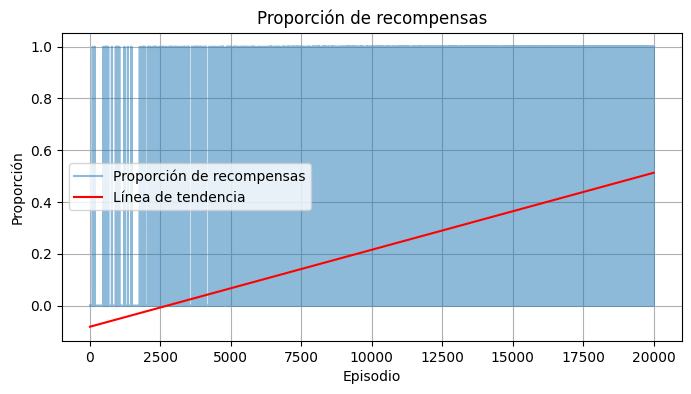

In [21]:
plot(rewards_per_episode_mc_off)  # Pass only rewards_per_episode

En la siguiente gráfica podemos indicar que el algoritmo Monte Carlo Off-Policy en FrozenLake-v1 está permitiendo que el agente aprenda progresivamente, pero la tendencia a episodios más largos puede indicar que el agente aún no ha convergido a una política óptima.
Inicialmente, los episodios presentan una gran variabilidad en la longitud, lo que indica que el agente aún no ha aprendido una estrategia eficiente para alcanzar el objetivo.
A medida que el entrenamiento avanza, los episodios tienden a aumentar en longitud, lo que sugiere que el agente está explorando más o encontrando caminos más largos antes de alcanzar el estado terminal.
La línea de tendencia roja muestra un ligero incremento en la duración media de los episodios, lo que puede indicar que la política aprendida no está optimizada para encontrar la ruta más corta.
La dispersión de valores sugiere que hay episodios ocasionales con longitudes extremadamente altas, lo cual puede deberse a una estrategia de exploración o a dificultades para encontrar la ruta óptima.

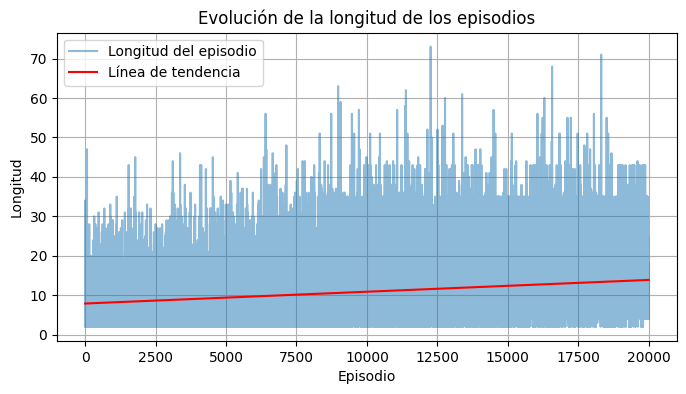

In [22]:
plot_episode_lengths(episodes_sizes_mc_off)

Extraemos la politica optima para despues poder mostrar un video con el camino solucion optimo encontrado por el agente:

In [23]:
# Extraer la política óptima para todos los estados
optimal_policy_vector = np.argmax(agent.Q, axis=1)
print("Política óptima (vector de acciones):\n", optimal_policy_vector)

# Evaluar la política en un episodio de prueba
action_log, frames_recorded = evaluate_policy(env_mc_off, optimal_policy_vector, seed=seed)
print("\nAcciones tomadas en la evaluación:\n", action_log)
print("\nGrid del entorno:\n", env_mc_on.render())

Política óptima (vector de acciones):
 [3 3 0 0 2 0 0 0 3 2 1 0 0 2 2 0]

Acciones tomadas en la evaluación:
 [3, 3, 0, 0, 1, 2, 2, 2, 2, 2]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


Mostramos el video:

In [24]:
video_dir = record_policy_with_fn(optimal_policy_fn, env=env_mc_off, video_dir="videos_mc_off")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_mc_off folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_mc_off/rl-video-episode-20000.mp4


Comparación

En este experimento, **Monte Carlo On-Policy y Off-Policy** tienen un desempeño equivalente en términos de recompensas. Esto puede indicar que en un entorno simple como FrozenLake-v1, la diferencia entre aprender con la política actual (On-Policy) o con una política distinta (Off-Policy) no tiene un impacto significativo en la capacidad del agente para resolver la tarea.

Ambos enfoques alcanzan una proporción de recompensas cercana a 1 en los primeros episodios, lo que indica que el agente logra aprender una política que le permite resolver el entorno de manera efectiva.
Sin embargo, las líneas parecen superpuestas y estáticas, lo que sugiere que ambas estrategias están convergiendo a un rendimiento muy similar.
A partir de los primeros 5000 episodios, la gráfica se vuelve completamente uniforme y saturada en 1, lo que indica que el agente ha aprendido a resolver el entorno de manera consistente y sin errores.
El hecho de que no se observe una variación significativa entre On-Policy y Off-Policy indica que en este entorno específico (FrozenLake-v1), ambos métodos funcionan de manera casi idéntica en términos de recompensas obtenidas.

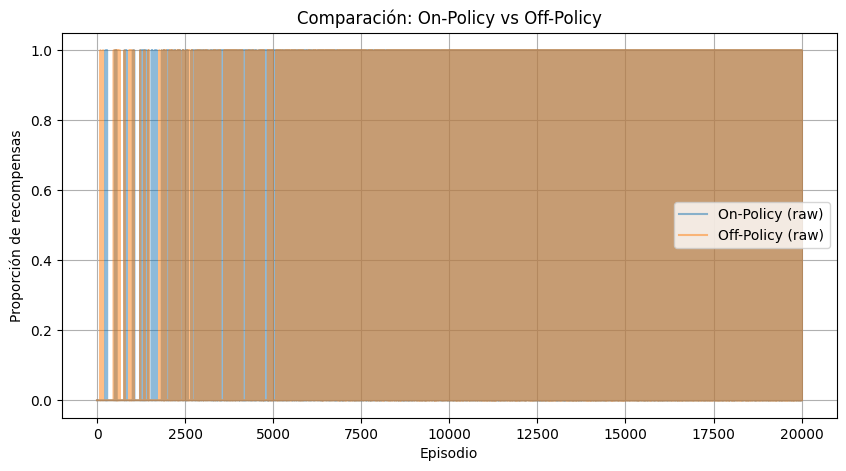

In [25]:
plot_comparison(rewards_per_episode_mc_on, rewards_per_episode_mc_off, True)

A diferencia de la gráfica anterior donde las proporciones de recompensa eran similares entre los métodos, aquí observamos que los episodios varían en longitud y hay bastante dispersión, lo que sugiere que el agente no siempre converge en una política completamente óptima. Además, el enfoque Off-Policy tiende a tener episodios más largos con más frecuencia, lo que puede indicar que no está aprendiendo una política tan eficiente como On-Policy en este caso.

En los primeros episodios, las longitudes varían mucho, lo que indica que el agente aún está explorando y no ha aprendido una estrategia eficiente.
A medida que avanza el entrenamiento, las longitudes siguen siendo variables, pero en general, se observa una tendencia al alza en algunos momentos, lo que puede indicar que el agente sigue explorando rutas más largas.
La dispersión sigue siendo bastante alta incluso en los últimos episodios, lo que sugiere que el agente no siempre sigue una estrategia óptima y a veces toma caminos más largos para completar la tarea.

**Comparación On-Policy vs Off-Policy**: Aunque ambos métodos tienen una distribución similar, Off-Policy (naranja) parece experimentar episodios más largos con más frecuencia, lo que sugiere que este enfoque podría estar explorando más o aprendiendo de una manera menos estable.

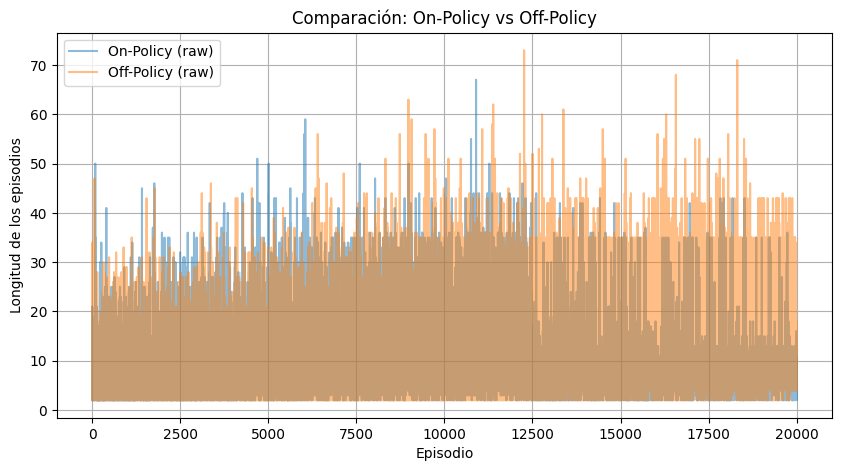

In [26]:
plot_comparison(episodes_sizes_mc_on, episodes_sizes_mc_off, False)

# **Diferencias Temporales**

Sarsa es un método de aprendizaje por diferencias temporales que opera de manera on-policy, lo que significa que evalúa y mejora la misma política que utiliza para seleccionar acciones. El nombre proviene de la secuencia ((S, A, R, S', A')): estado actual, acción tomada, recompensa recibida, siguiente estado y la siguiente acción elegida por la política (\varepsilon)-greedy. La actualización de la función de acción-valor (Q) incorpora tanto la recompensa inmediata como el valor estimado de la siguiente acción que realmente se tomará, capturando así la naturaleza on-policy del método.

A diferencia de métodos que buscan el máximo futuro, Sarsa se basa en la acción que efectivamente se elige en el siguiente paso. Esto hace que, en escenarios donde la exploración pueda ser riesgosa, Sarsa sea más conservador y se ajuste mejor a la política que está en uso, ya que incluye la probabilidad de acciones subóptimas en el cálculo de los retornos esperados. En consecuencia, Sarsa tiende a aprender un comportamiento que equilibra la exploración y la explotación de acuerdo con la política vigente en cada momento.

Q-Learning es otro método de aprendizaje por diferencias temporales, pero a diferencia de Sarsa, es off-policy. Su objetivo es aprender la política óptima, independientemente de las acciones que se tomen durante la recolección de datos. En lugar de basarse en la acción que realmente se escoge en el siguiente paso, Q-Learning estima el valor del mejor movimiento posible para el estado siguiente. La fórmula de actualización de  Q(s,a)  utiliza  maxa′Q(s′,a′) , es decir, el valor máximo entre todas las acciones potenciales en el siguiente estado.

Esta aproximación off-policy permite que el agente aprenda de manera más agresiva la política óptima, ya que no considera la política de exploración al estimar los valores futuros. Sin embargo, también puede generar comportamientos más arriesgados si no se controla adecuadamente la exploración, ya que Q-Learning asume que, en cada paso, siempre se tomará la acción óptima en el futuro, independientemente de la política que realmente se siga para recopilar la experiencia.

Definimos Sarsa y Q learning

In [27]:
# Clase SARSA Agent
class SARSAAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax(self.Q[state])  # Explotación

    def update(self, state, action, reward, next_state, next_action, done):
        target = reward + (0 if done else self.gamma * self.Q[next_state, next_action])
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

# Clase Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax(self.Q[state])  # Explotación

    def update(self, state, action, reward, next_state, done):
        target = reward + (0 if done else self.gamma * np.max(self.Q[next_state]))
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Iniciamos Sarsa y lo entrenamos

In [28]:
# Crear un nuevo entorno con grabación de video
env_sarsa = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_sarsa = gym.wrappers.RecordVideo(env_sarsa, video_folder="videos_sarsa")

agent = SARSAAgent(
    env=env_sarsa,
    gamma=GAMMA,
    alpha=0.1,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_sarsa = []
episodes_sizes_sarsa = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_sarsa.reset(seed=seed)
    action = agent.get_action(obs)  # SARSA necesita elegir la acción antes de empezar el episodio
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa.step(action)
        done = terminated or truncated
        next_action = agent.get_action(next_obs) if not done else None

        # Actualizar SARSA en cada paso
        agent.update(obs, action, reward, next_obs, next_action, done)

        # Actualizar estado y métricas
        obs, action = next_obs, next_action
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_sarsa.append(episode_reward)
    episodes_sizes_sarsa.append(episode_steps)

    # Para mostrar la evolución
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")


 12%|█▏        | 2392/20000 [00:01<00:06, 2706.57it/s]

Éxito promedio: 0.2185, Épsilon: 0.16559836487980828


 22%|██▏       | 4313/20000 [00:02<00:05, 2924.45it/s]

Éxito promedio: 0.5195, Épsilon: 0.01582273706228526


 32%|███▏      | 6416/20000 [00:03<00:04, 2928.27it/s]

Éxito promedio: 0.674, Épsilon: 0.002


 42%|████▏     | 8360/20000 [00:03<00:03, 3097.63it/s]

Éxito promedio: 0.75525, Épsilon: 0.002


 53%|█████▎    | 10571/20000 [00:04<00:02, 3216.87it/s]

Éxito promedio: 0.8029, Épsilon: 0.002


 63%|██████▎   | 12507/20000 [00:05<00:02, 3207.10it/s]

Éxito promedio: 0.8353333333333334, Épsilon: 0.002


 72%|███████▏  | 14485/20000 [00:05<00:01, 3251.87it/s]

Éxito promedio: 0.8583571428571428, Épsilon: 0.002


 80%|████████  | 16046/20000 [00:06<00:02, 1396.96it/s]

Éxito promedio: 0.87525, Épsilon: 0.002


 93%|█████████▎| 18659/20000 [00:07<00:00, 3472.03it/s]

Éxito promedio: 0.8887777777777778, Épsilon: 0.002


100%|██████████| 20000/20000 [00:07<00:00, 2568.44it/s]


El algoritmo SARSA On-Policy está aprendiendo de manera progresiva, pero de una forma más fluctuante e inestable en comparación con Monte Carlo. Aunque la tendencia general es positiva, la alta variabilidad en la proporción de recompensas sugiere que el agente sigue explorando o que la política aprendida no es del todo estable.

Esto puede deberse a que SARSA es un método On-Policy, lo que significa que su política se actualiza continuamente mientras sigue explorando, lo que puede hacer que su aprendizaje sea más errático.

Se pueden observar 3 fases clave:

**Fase inicial (primeros 5000 episodios):**

La proporción de recompensas comienza en un valor relativamente alto, cercano a 0.6.
Sin embargo, hay una interrupción en la que la proporción parece caer abruptamente a cero en algunos momentos. Esto podría deberse a exploraciones fallidas o a que el agente todavía está aprendiendo.

**Fase intermedia (5000 - 15000 episodios):**

Se observan fluctuaciones con episodios en los que el agente no obtiene recompensa (proporción = 0).
Esto indica que el agente aún no ha aprendido completamente una política óptima y sigue explorando diferentes rutas.

**Fase final (15000 - 20000 episodios):**

Se observa una mayor estabilidad, con varios episodios donde la recompensa es 1.
La línea de tendencia roja muestra una mejora gradual y constante, lo que indica que el agente está aprendiendo y mejorando su desempeño con el tiempo.

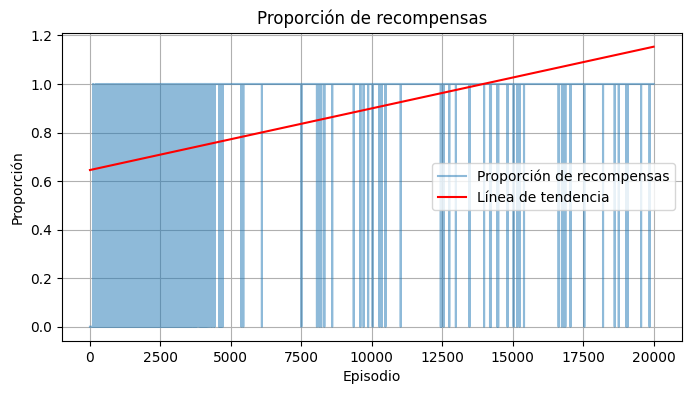

In [29]:
plot(rewards_per_episode_sarsa)  # Pass only rewards_per_episode

Esta gráfica muestra la evolución de la longitud de los episodios a lo largo del entrenamiento del agente utilizando **SARSA (On-Policy) en el entorno FrozenLake-v1**
El algoritmo SARSA On-Policy ha logrado mejorar su desempeño a lo largo del entrenamiento, reduciendo la longitud de los episodios, lo que indica una mayor eficiencia en la toma de decisiones. Sin embargo, la variabilidad observada en algunos episodios sugiere que aún existe exploración o inestabilidad en la política aprendida.

Este comportamiento es característico de métodos On-Policy, ya que la política sigue cambiando mientras el agente aprende, lo que puede generar cierta inestabilidad en el aprendizaje.

Se detallan las 3 siguientes fases:

**Fase inicial (0 - 5000 episodios):**

Se observa una gran variabilidad en la longitud de los episodios.
Algunos episodios terminan rápido (baja longitud), mientras que otros pueden superar los 100 pasos, lo que sugiere que el agente está explorando de manera errática.
Posiblemente, el agente aún no ha aprendido una estrategia eficiente y toma rutas subóptimas.

**Fase intermedia (5000 - 10000 episodios):**

Se nota una reducción progresiva en la longitud de los episodios.
Menos episodios tienen una longitud excesiva, lo que indica que el agente está aprendiendo a llegar al objetivo de manera más eficiente.
Hay una caída en la cantidad de episodios largos, lo que sugiere una mejora en la estrategia del agente.

**Fase final (10000 - 20000 episodios):**

Se mantiene una longitud baja y estable en la mayoría de los episodios.
Algunos episodios aún presentan un aumento en longitud, lo que podría deberse a la exploración ocasional o a la dificultad del entorno.
La línea roja muestra una tendencia ligeramente descendente, lo que confirma que el agente ha reducido el número de pasos necesarios para resolver el entorno.

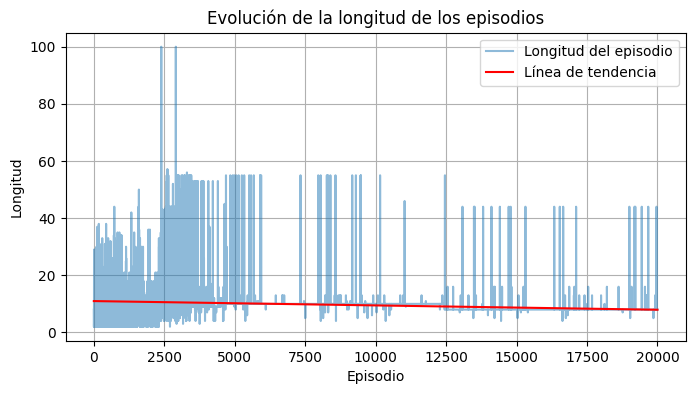

In [30]:
plot_episode_lengths(episodes_sizes_sarsa)

In [31]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_sarsa, agent.Q)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_sarsa.render())

Política óptima obtenida:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

Acciones tomadas:
 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 2, 1, 2, 

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180

In [32]:
# Definimos la función de política GREEDY a partir de la Q del agente
def greedy_policy(state):
    import numpy as np
    return np.argmax(agent.Q[state])

Mostramos el video:

In [33]:
video_dir = record_policy_with_fn(greedy_policy, env=env_sarsa, video_dir="videos_sarsa")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_sarsa folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_sarsa/rl-video-episode-20000.mp4


Iniciamos QLearning y lo entranamos:

In [34]:
env_qlearning = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_qlearning = gym.wrappers.RecordVideo(env_qlearning, video_folder="videos_qlearning")

agent = QLearningAgent(
    env=env_qlearning,
    gamma=GAMMA,
    alpha=0.2,
    epsilon=EPSILON,
    epsilon_decay=0.9995,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_ql = []
episodes_sizes_ql = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_qlearning.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agent.get_action(obs)  # Se elige la acción aquí en cada paso
        next_obs, reward, terminated, truncated, info = env_qlearning.step(action)
        done = terminated or truncated

        agent.update(obs, action, reward, next_obs, done)

        # Actualizar estado y métricas
        obs = next_obs
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_ql.append(episode_reward)
    episodes_sizes_ql.append(episode_steps)

    # Para mostrar la evolución
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

  9%|▉         | 1878/20000 [00:01<00:11, 1594.63it/s]

Éxito promedio: 0.838, Épsilon: 0.002


 21%|██        | 4176/20000 [00:04<00:10, 1461.51it/s]

Éxito promedio: 0.911, Épsilon: 0.002


 32%|███▏      | 6329/20000 [00:05<00:07, 1936.77it/s]

Éxito promedio: 0.9398333333333333, Épsilon: 0.002


 42%|████▏     | 8355/20000 [00:06<00:04, 2467.38it/s]

Éxito promedio: 0.954625, Épsilon: 0.002


 52%|█████▏    | 10363/20000 [00:07<00:03, 2470.40it/s]

Éxito promedio: 0.9632, Épsilon: 0.002


 62%|██████▏   | 12364/20000 [00:07<00:03, 2430.59it/s]

Éxito promedio: 0.9686666666666667, Épsilon: 0.002


 72%|███████▏  | 14467/20000 [00:08<00:02, 2578.47it/s]

Éxito promedio: 0.9715714285714285, Épsilon: 0.002


 82%|████████▏ | 16367/20000 [00:09<00:01, 2709.76it/s]

Éxito promedio: 0.9749375, Épsilon: 0.002


 91%|█████████ | 18218/20000 [00:10<00:00, 2539.76it/s]

Éxito promedio: 0.9771666666666666, Épsilon: 0.002


100%|██████████| 20000/20000 [00:10<00:00, 1869.14it/s]


Esta gráfica muestra la evolución de la proporción de recompensas a lo largo del entrenamiento utilizando Q-Learning (Off-Policy) en el entorno FrozenLake-v1.
Q-Learning (Off-Policy) ha logrado aprender una estrategia efectiva y estable.
Aunque hubo fases de exploración con caídas en la recompensa, la tendencia general muestra que el agente ha mejorado progresivamente.
Al ser un método Off-Policy, la estabilidad del aprendizaje es mayor que en métodos On-Policy (como SARSA), lo que le permite alcanzar una alta tasa de éxito de manera más consistente.

Para dar mejor detalle de la gráfica caben destacar las 3 siguientes fases:

**Fase inicial (0 - 2000 episodios):**

La proporción de recompensas es alta desde el comienzo, indicando que el agente puede haber encontrado estrategias exitosas tempranamente.
Sin embargo, hay mucha variabilidad con episodios donde la proporción cae a cero, lo que sugiere que el agente aún está explorando o que el entorno tiene un componente estocástico que dificulta la consistencia en el éxito.

**Fase intermedia (2000 - 10000 episodios):**

Se observan fluctuaciones en la proporción de recompensas, pero la tendencia sigue ligeramente en aumento.
En ciertos momentos, el agente parece no recibir ninguna recompensa en varios episodios seguidos, lo que puede deberse a exploraciones fallidas o a la dinámica del entorno (p.ej., caídas en los lagos).
Sin embargo, el Q-Learning al ser Off-Policy aprende de manera más estable, acumulando conocimiento de episodios anteriores sin depender estrictamente de la política seguida en cada paso.

**Fase final (10000 - 20000 episodios):**

La línea de tendencia roja muestra un incremento constante en la proporción de recompensas, acercándose a 1.
Esto indica que el agente ha aprendido una política estable y efectiva, logrando el objetivo en la mayoría de los episodios.

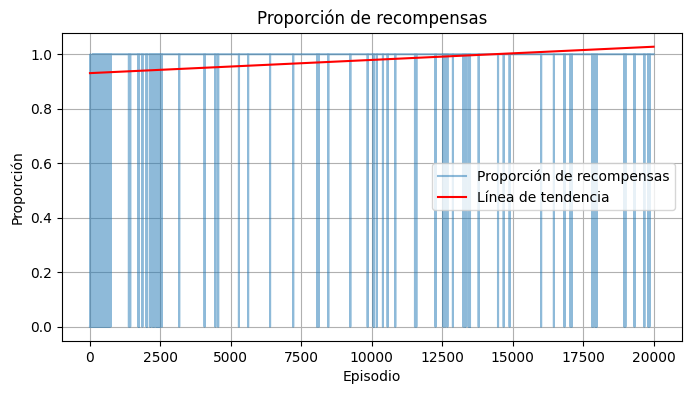

In [35]:
plot(rewards_per_episode_ql)  # Pass only rewards_per_episode

Esta gráfica se muestra la evolución de la longitud de los episodios en función del número de episodios en un entorno Frozen Lake utilizando Q-learning off-policy.

La gráfica indica que el agente está aprendiendo y mejorando su desempeño con el tiempo, reduciendo la cantidad de pasos necesarios para completar la tarea en Frozen Lake.

La longitud del episodio (en azul) inicialmente muestra valores altos y variables, lo que sugiere que el agente está explorando y aún no ha aprendido una estrategia eficiente.
Con el tiempo, la longitud promedio de los episodios disminuye (línea roja de tendencia), lo que indica que el agente está aprendiendo una estrategia más óptima para alcanzar su objetivo en menos pasos.

También se puede observar que en los primeros episodios, la longitud de los episodios varía significativamente. Esto es normal, ya que el agente está explorando y probando diferentes acciones sin tener aún una buena política establecida.

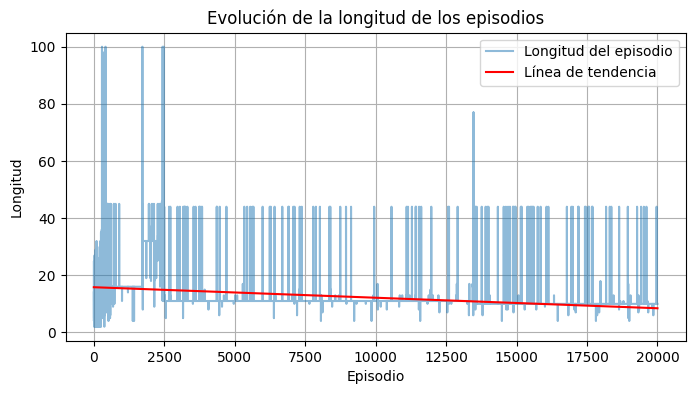

In [36]:
plot_episode_lengths(episodes_sizes_ql)

In [37]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_qlearning, agent.Q)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_qlearning.render())

Política óptima obtenida:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

Acciones tomadas:
 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 3, 1, 1, 2, 

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 2

Mostramos el video:

In [38]:
video_dir = record_policy_with_fn(greedy_policy, env=env_qlearning, video_dir="videos_qlearning")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_qlearning folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_qlearning/rl-video-episode-20000.mp4


En esta gráfica se está comparando el rendimiento de los enfoques SARSA y Q-learning. En ella, se muestra la proporción de recompensas por episodio a lo largo del tiempo para ambos algoritmos.

Detalles de la gráfica:

Eje Y (Proporción de recompensas):
Representa la proporción de episodios en los que el agente ha recibido una recompensa. Un valor de 1.0 significa que el agente recibió una recompensa en ese episodio, mientras que un valor de 0.0 indica que no recibió ninguna recompensa.

Espacios en blanco entre episodios:
Los espacios en blanco indican que en varios episodios, ninguno de los dos algoritmos está recibiendo recompensas, lo que sugiere que ambos están fallando en alcanzar el objetivo en esos casos. Estos periodos pueden corresponder a momentos en los que los algoritmos aún están explorando o encontrando situaciones que no han aprendido a resolver bien.

**Comparación entre SARSA y Q Learning**

*SARSA (On-Policy):*

Sigue una estrategia más conservadora y segura porque evalúa y actualiza la política de la misma manera que explora el entorno.
Como resultado, podría ser menos eficiente en encontrar la mejor solución, pero suele evitar cambios bruscos en su política y tiene una menor probabilidad de explorar caminos riesgosos.
En la gráfica, SARSA parece ser algo más estable, pero con una proporción de recompensas que no siempre alcanza el máximo.

*Q-learning (Off-Policy):*

Es más agresivo, actualizando su política basada en la estimación de la política óptima, lo que puede permitirle encontrar soluciones más rápidas y eficientes.
Sin embargo, este enfoque puede ser más inestable y experimentar periodos en los que el rendimiento fluctúa más.
En la gráfica, Q-learning muestra una mayor variabilidad al inicio, pero a medida que avanza parece alcanzar recompensas de manera más consistente.


En conclusión ambos enfoques tienen momentos de alta variabilidad en la proporción de recompensas. SARSA parece más estable, mientras que Q-learning, al ser más agresivo, podría tener más potencial de mejora, pero también más inestabilidad. De momento, podemos afirmar que los métodos de Monte Carlo nos otorgan mejores resultados que los métodos de diferencias temporales.

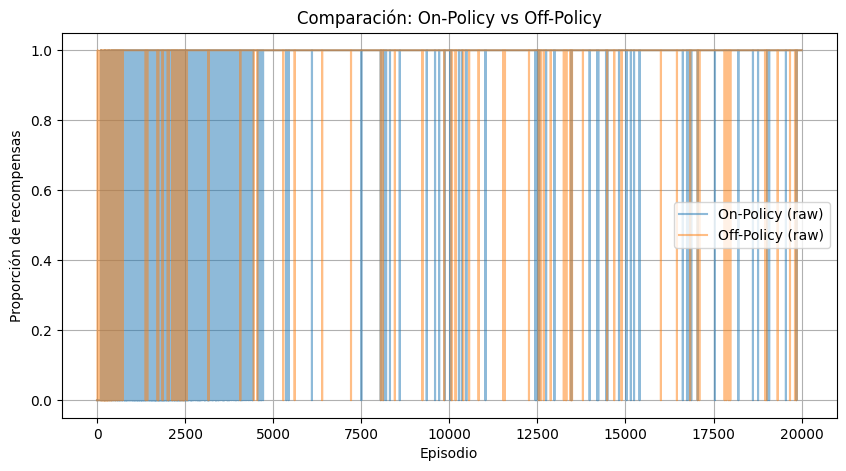

In [39]:
plot_comparison(rewards_per_episode_sarsa, rewards_per_episode_ql, True)

En la siguiente gráfica podemos observar la longitud de los episodios, y tal y como hemos visto q-learning presenta en promedio episodios mas cortos, aunque realmente cualquiera de los dos métodos están teniendo ciertos problemas para converger correctamente y nos indican un aprendizaje errático que no ha conseguido identificar políticas óptimas.


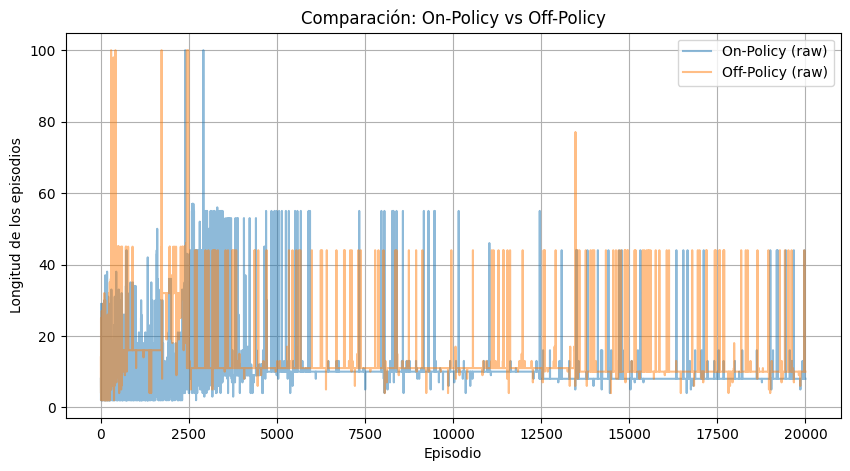

In [40]:
plot_comparison(episodes_sizes_sarsa, episodes_sizes_ql, False)

# **Control Con Aproximaciones**

## SARSA Semi-Gradiente

**SARSA Semi-Gradiente** es una extensión del algoritmo SARSA que integra la aproximación de funciones para estimar la función de acción-valor (Q(s,a)) mediante un modelo parametrizado, como puede ser un modelo lineal o una red neuronal. En este enfoque, la actualización de los parámetros se realiza utilizando el gradiente de la función aproximada respecto a los parámetros, pero de forma "semi-gradiente", ya que se considera fijo el valor objetivo obtenido a partir de la política en el siguiente estado. Esto permite aplicar actualizaciones incrementales basadas en la diferencia temporal (TD error) sin propagar el gradiente a través del término objetivo, facilitando la estabilidad y eficiencia del aprendizaje en espacios de estados de alta dimensión o continuos.

Inicializamos SARSA Semigradiente

In [41]:
class SARSASemiGradient:
    def __init__(self, env, alpha=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.9999, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializar pesos w con valores pequeños
        self.w = np.random.rand(env.observation_space.n, env.action_space.n) * 0.01

    def featurize_state_action(self, state, action):
        """Codificación simple de estado-acción como one-hot vector"""
        features = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        features[state, action] = 1
        return features

    def q_value(self, state, action):
        """Calcula Q(s,a) como w^T * x(s,a)"""
        features = self.featurize_state_action(state, action)
        return np.sum(self.w * features)

    def get_action(self, state):
        """Política epsilon-greedy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax([self.q_value(state, a) for a in range(self.env.action_space.n)])  # Explotación

    def update(self, state, action, reward, next_state, next_action, done):
        """Actualización de pesos w con semi-gradiente"""
        features = self.featurize_state_action(state, action)
        target = reward + (0 if done else self.gamma * self.q_value(next_state, next_action))
        error = target - self.q_value(state, action)
        self.w += self.alpha * error * features  # Gradiente ascendente

        # Reducir epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Iniciamos agente y lo entrenamos:

In [42]:
# Crear entorno con grabación de video
env_sarsa_sg = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_sarsa_sg = gym.wrappers.RecordVideo(env_sarsa_sg, video_folder="videos_sarsa_sg")

# Inicializar el agente SARSA Semi-Gradiente
agent = SARSASemiGradient(
    env=env_sarsa_sg,
    alpha=0.01,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_sarsa_sg = []
episodes_sizes_sarsa_sg = []

# Para mostrar la evolución en consola
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_sarsa_sg.reset(seed=seed)
    action = agent.get_action(obs)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa_sg.step(action)
        done = terminated or truncated
        next_action = agent.get_action(next_obs) if not done else None

        agent.update(obs, action, reward, next_obs, next_action, done)

        # Actualizar estado y métricas
        obs, action = next_obs, next_action
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_sarsa_sg.append(episode_reward)
    episodes_sizes_sarsa_sg.append(episode_steps)

    # Mostrar información de progreso
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

print("Entrenamiento de SARSA Semi-Gradiente completado.")

 10%|█         | 2024/20000 [00:03<01:02, 288.37it/s]

Éxito promedio: 0.097, Épsilon: 0.0626220056786113


 20%|██        | 4027/20000 [00:10<01:16, 208.98it/s]

Éxito promedio: 0.5005, Épsilon: 0.002


 30%|███       | 6001/20000 [00:16<00:59, 233.57it/s]

Éxito promedio: 0.6605, Épsilon: 0.002


 40%|████      | 8030/20000 [00:26<00:45, 263.65it/s]

Éxito promedio: 0.74075, Épsilon: 0.002


 50%|█████     | 10020/20000 [00:33<00:38, 259.82it/s]

Éxito promedio: 0.7888, Épsilon: 0.002


 60%|██████    | 12008/20000 [00:39<00:28, 284.96it/s]

Éxito promedio: 0.82125, Épsilon: 0.002


 70%|███████   | 14001/20000 [00:46<00:17, 345.14it/s]

Éxito promedio: 0.8442857142857143, Épsilon: 0.002


 80%|████████  | 16019/20000 [00:53<00:16, 245.14it/s]

Éxito promedio: 0.8604375, Épsilon: 0.002


 90%|█████████ | 18029/20000 [01:01<00:08, 230.82it/s]

Éxito promedio: 0.8736666666666667, Épsilon: 0.002


100%|██████████| 20000/20000 [01:08<00:00, 289.94it/s]

Entrenamiento de SARSA Semi-Gradiente completado.


En esta gráfica se muestra la proporción de recompensas a lo largo del tiempo en Frozen Lake utilizando SARSA semigradiente, un método basado en aproximación de funciones en lugar de una tabla Q.

La línea roja indica que la proporción de recompensas aumenta a medida que se entrenan más episodios.
Esto sugiere que el agente está aprendiendo y mejorando su desempeño con el tiempo.

Se observa un patrón de franjas blancas en la gráfica, lo que significa que hay episodios en los que el agente no recibe recompensas.
Sin embargo, la tendencia general sigue en aumento, lo que indica que, aunque el aprendizaje no es completamente estable, está funcionando.

El agente está aprendiendo de manera efectiva, con una tendencia positiva en la proporción de recompensas.
SARSA semigradiente está funcionando bien en este entorno, bastante mejor que SARSA tabular en este escenario.

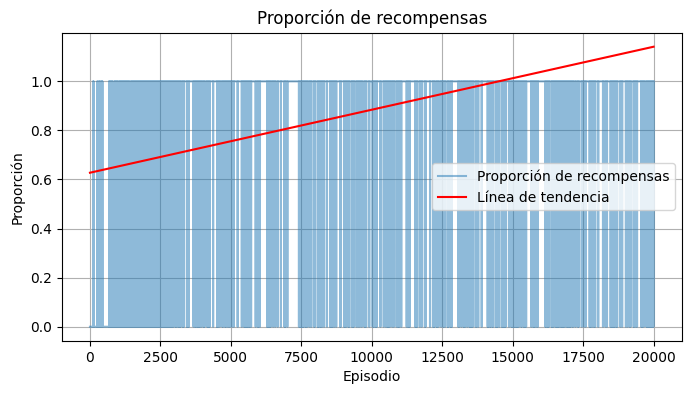

In [43]:
plot(rewards_per_episode_sarsa_sg)  # Pass only rewards_per_episode

Esta gráfica muestra la evolución de la longitud de los episodios en Frozen Lake utilizando SARSA semigradiente. La longitud de un episodio indica cuántos pasos toma el agente antes de alcanzar el objetivo o caer en un estado terminal.

La línea roja de tendencia muestra que, en promedio, la longitud de los episodios está aumentando con el tiempo.
Esto puede significar que el agente está explorando más caminos antes de encontrar la solución óptima, o que el aprendizaje aún no ha convergido del todo.

Al inicio, la longitud de los episodios varía enormemente, alcanzando picos de más de 70 pasos.
Esto sugiere que el agente al principio está explorando mucho y no tiene aún una estrategia clara.

Luego de unos 2500 episodios, la longitud de los episodios parece volverse más estable, con valores más consistentes en un rango de 10 a 30 pasos.
Sin embargo, sigue habiendo episodios en los que el agente necesita más pasos, lo que puede ser un signo de exploración continua o inestabilidad en la estrategia.


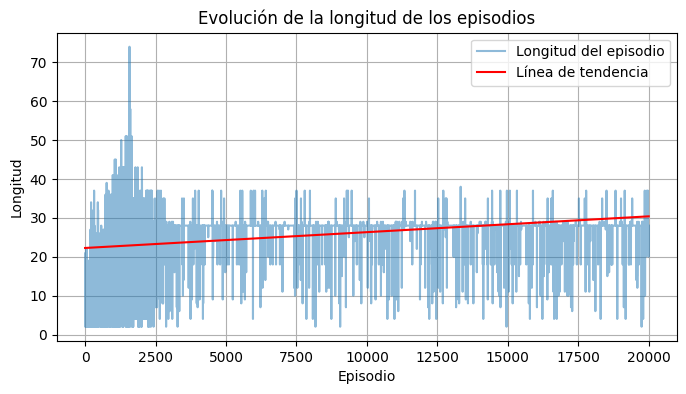

In [44]:
plot_episode_lengths(episodes_sizes_sarsa_sg)

Función para evaluar la politica optima:

In [45]:
def optimal_policy_from_q(env, agent):
    """Evalúa la política óptima aprendida a partir de los valores de Q estimados por SARSA SG."""
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    action_log = []
    frames = []

    for state in range(env.observation_space.n):
        optimal_policy[state] = np.argmax([agent.q_value(state, a) for a in range(env.action_space.n)])

    # Simulación de la política óptima
    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        frames.append(env.render())  # Guardar la imagen del entorno
        action = optimal_policy[state]
        action_log.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return optimal_policy, action_log, frames

In [46]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_sarsa_sg, agent)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_qlearning.render())

Política óptima obtenida:
 [3 3 0 3 0 1 2 2 3 1 2 0 3 3 3 1]

Acciones tomadas:
 [3, 3, 0, 2, 0, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 2, 2, 3, 3, 3]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [47]:
def greedy_policy_sarsa_sg(state, agent):
    """Selecciona la acción óptima para SARSA Semi-Gradiente usando la función aproximadora."""
    return np.argmax([agent.q_value(state, a) for a in range(agent.env.action_space.n)])

In [48]:
def record_policy_with_fn_SarsaDQL(policy_fn, agent, env, num_episodes=1, video_dir="videos"):
    """Graba un video ejecutando una política greedy sin exploración."""
    os.makedirs(video_dir, exist_ok=True)

    env = gym.wrappers.RecordVideo(env, video_folder=video_dir, episode_trigger=lambda ep: ep == 0)

    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        action = policy_fn(state, agent)  # Aplicar la política óptima aprendida
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

    return video_dir


Mostramos el video:


In [49]:
# Grabar el video con la mejor política aprendida
video_dir = record_policy_with_fn_SarsaDQL(greedy_policy_sarsa_sg, agent, env_sarsa_sg, video_dir="videos_sarsa_sg")

# Obtener el último video grabado
latest_video_file = get_latest_episode_video_file(video_dir)

# Mostrar información del video grabado
print("Video grabado:", latest_video_file)

# Mostrar el video en el notebook
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_sarsa_sg folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_sarsa_sg/rl-video-episode-20000.mp4


## Deep Q-Learning

Deep Q-Learning (DQN) es una extensión de Q-Learning que emplea redes neuronales profundas para aproximar la función de acción-valor $Q(s, a)$ en lugar de usar una tabla. En este método, la red toma como entrada el estado del entorno y produce los valores $Q$ estimados para cada acción posible, permitiendo escalar el aprendizaje por refuerzo a espacios de estado de alta dimensión. Durante el entrenamiento, se utilizan técnicas como **experience replay** (para romper la correlación entre muestras) y **target networks** (para estabilizar la convergencia), reduciendo la varianza y mejorando la estabilidad de la actualización de parámetros.

Definimos la clase Deep Q Learning

In [50]:
import torch.optim as optim
import torch.nn as nn
import torch
import random

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # No activación final (Q-values)

In [51]:
class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01, batch_size=32, target_update_freq=100):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq  # Cada cuántos pasos actualizamos la target_network

        # Red principal y Red Objetivo
        self.model = DQN(env.observation_space.n, env.action_space.n)
        self.target_network = DQN(env.observation_space.n, env.action_space.n)
        self.target_network.load_state_dict(self.model.state_dict())  # Inicializar con los mismos pesos

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        self.criterion = nn.MSELoss()

        self.replay_buffer = []  # Buffer de memoria para Experience Replay
        self.steps = 0  # Contador de pasos totales

    def get_action(self, state):
        """Estrategia epsilon-greedy para elegir acción."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración

        # Convertir el estado a representación one-hot
        state_tensor = torch.tensor(np.eye(self.env.observation_space.n)[state], dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            q_values = self.model(state_tensor)  # Obtener valores Q

        return torch.argmax(q_values, dim=1).item()  # Seleccionar la mejor acción

    def update(self, state, action, reward, next_state, done):
        """Guarda la experiencia y entrena con un minibatch."""
        self.replay_buffer.append((state, action, reward, next_state, done))

        if len(self.replay_buffer) < self.batch_size:  # Esperar hasta que haya suficientes datos
            return

        # Seleccionar un minibatch de experiencias
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # **Corrección: Indexar `np.eye()` correctamente**
        states = torch.tensor(np.eye(self.env.observation_space.n)[list(states)], dtype=torch.float32)
        next_states = torch.tensor(np.eye(self.env.observation_space.n)[list(next_states)], dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Calcular Q-target con la red objetivo
        with torch.no_grad():
            target_q_values = rewards + (1 - dones) * self.gamma * torch.max(self.target_network(next_states), dim=1)[0]

        # Calcular Q actual de la red principal
        q_values = self.model(states).gather(1, torch.tensor(actions, dtype=torch.long).unsqueeze(1)).squeeze()

        # Calcular pérdida y actualizar pesos
        loss = self.criterion(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Cada ciertos pasos actualizamos la red objetivo
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.model.state_dict())

Inicializamos el entorno y entrenamos el agente:

In [52]:
# Inicializar entorno con grabación de video cada 100 episodios
env_dqn = gym.make("FrozenLake-v1", render_mode="rgb_array")
env_dqn = gym.wrappers.RecordVideo(env_dqn, video_folder="videos_dqn", episode_trigger=lambda ep: ep % 100 == 0)

# Inicializar el agente DQN
agent = DQNAgent(
    env=env_dqn,
    alpha=0.001,  # Learning rate bajo para redes neuronales
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.9995,
    min_epsilon=0.01
)

# Definir variables de entrenamiento
NUM_EPISODES = 20000
rewards_per_episode_dqn = []
episodes_sizes_dqn = []

stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Entrenamiento del DQN
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_dqn.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agent.get_action(obs)  # Se elige la acción en cada paso
        next_obs, reward, terminated, truncated, info = env_dqn.step(action)
        done = terminated or truncated

        agent.update(obs, action, reward, next_obs, done)

        # Actualizar estado y métricas
        obs = next_obs
        episode_reward += reward
        episode_steps += 1

    # Guardar métricas del episodio
    stats += episode_reward
    list_stats.append(stats / (episode + 1))
    rewards_per_episode_dqn.append(episode_reward)
    episodes_sizes_dqn.append(episode_steps)

    # Reducir epsilon gradualmente
    agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

    # Mostrar información de progreso
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

print("Entrenamiento de Deep Q-Learning completado.")


 10%|█         | 2008/20000 [00:50<09:26, 31.74it/s]

Éxito promedio: 0.07, Épsilon: 0.36760355841993914


 20%|██        | 4000/20000 [02:27<11:21, 23.48it/s]

Éxito promedio: 0.20275, Épsilon: 0.1351999761510762


 30%|██▉       | 5999/20000 [04:19<11:57, 19.51it/s]

Éxito promedio: 0.35733333333333334, Épsilon: 0.04972485475880578


 40%|████      | 8005/20000 [05:45<07:43, 25.90it/s]

Éxito promedio: 0.485375, Épsilon: 0.018288177640071544


 50%|█████     | 10001/20000 [07:04<08:14, 20.23it/s]

Éxito promedio: 0.5753, Épsilon: 0.01


 60%|██████    | 12002/20000 [08:19<06:13, 21.41it/s]

Éxito promedio: 0.6381666666666667, Épsilon: 0.01


 70%|███████   | 14002/20000 [09:32<09:27, 10.57it/s]

Éxito promedio: 0.6833571428571429, Épsilon: 0.01


 80%|████████  | 16004/20000 [10:42<02:31, 26.35it/s]

Éxito promedio: 0.7170625, Épsilon: 0.01


 90%|█████████ | 18007/20000 [11:54<01:09, 28.54it/s]

Éxito promedio: 0.7436666666666667, Épsilon: 0.01


100%|██████████| 20000/20000 [13:03<00:00, 25.52it/s]

Entrenamiento de Deep Q-Learning completado.


Esta gráfica muestra la proporción de recompensas en Frozen Lake utilizando Deep Q-Learning (DQN). En este contexto, la proporción de recompensas representa la cantidad de veces que el agente logra alcanzar el objetivo en cada episodio.
La línea de tendencia es creciente, lo que indica que la proporción de recompensas aumenta de manera constante a lo largo del entrenamiento.
Esto sugiere que el agente está aprendiendo de forma efectiva, mejorando su capacidad para alcanzar el objetivo con el tiempo.
La región azul está casi completamente rellena, lo que sugiere que el agente está obteniendo recompensas en la mayoría de los episodios.
Esto indica que el modelo ha aprendido bien la tarea.

**Deep Q-Learning está funcionando bien** y logrando que el agente aprenda a completar la tarea de forma consistente.
La tendencia creciente es una buena señal de aprendizaje efectivo.





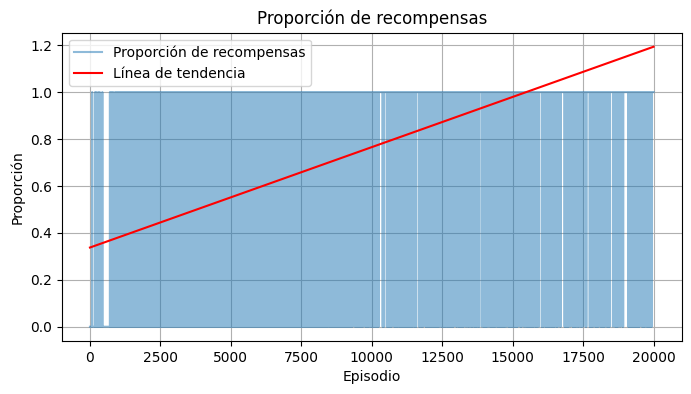

In [53]:
plot(rewards_per_episode_dqn)  # Pass only rewards_per_episode

Esta gráfica muestra la evolución de la longitud de los episodios en Frozen Lake utilizando Deep Q-Learning (DQN).

Al inicio, la longitud de los episodios es más baja y relativamente estable.
A medida que avanza el entrenamiento, la longitud de los episodios se vuelve mucho más variable, con episodios largos y cortos alternándose.

La línea de tendencia muestra una ligera disminución en la longitud promedio de los episodios.
Esto indica que, con el tiempo, el agente está encontrando caminos más cortos para resolver el problema, lo cual es una buena señal.

Hay episodios con longitudes muy altas (cercanas a 100), lo que sugiere que en algunas ocasiones el agente tarda mucho en resolver el problema o está atrapado en estrategias subóptimas, pero si logra optimizar su estrategia en la mayoría de los casos.

En conclusión deep Q-Learning está aprendiendo a resolver el problema, pero la alta variabilidad en la longitud de los episodios sugiere que aún hay exploración y no una total convergencia.La tendencia decreciente es buena porque indica que el agente reduce en promedio la cantidad de pasos necesarios para alcanzar su objetivo.



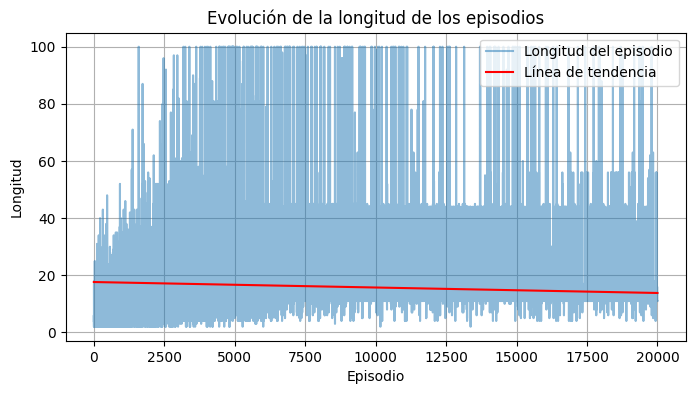

In [54]:
plot_episode_lengths(episodes_sizes_dqn)

Funcion para evaluar la política óptima aprendida a partir de los valores de Q estimados por la red neuronal en DQN

In [55]:
def optimal_policy_from_dqn(env, agent):
    """Evalúa la política óptima aprendida a partir de los valores de Q estimados por la red neuronal en DQN."""
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    action_log = []
    frames = []

    for state in range(env.observation_space.n):
        # Predecir Q(s,a) con la red neuronal y elegir la mejor acción
        state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
        optimal_policy[state] = torch.argmax(agent.model(state_tensor)).item()

    # Simulación de la política óptima
    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        frames.append(env.render())  # Guardar la imagen del entorno
        action = optimal_policy[state]
        action_log.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return optimal_policy, action_log, frames


In [56]:
# Evaluar la política óptima aprendida por Deep Q-Learning
optimal_policy_dqn, action_log_dqn, frames_dqn = optimal_policy_from_dqn(env_dqn, agent)

# Mostrar resultados
print("Política óptima obtenida en DQN:\n", optimal_policy_dqn)
print("\nAcciones tomadas:\n", action_log_dqn)
print("\nGrid del entorno:\n", env_dqn.render())  # Mostrar el entorno de DQN


Política óptima obtenida en DQN:
 [0 3 0 3 0 0 2 1 3 1 0 1 1 2 2 1]

Acciones tomadas:
 [0, 0, 0, 0, 3, 1, 3, 1, 2, 2, 2]

Grid del entorno:
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [57]:
def greedy_policy_dqn(state, agent):
    """Selecciona la acción óptima para DQN usando la red neuronal."""
    state_tensor = torch.tensor(np.eye(agent.env.observation_space.n)[state], dtype=torch.float32)
    return torch.argmax(agent.model(state_tensor)).item()

Mostramos el video:

In [58]:
# Grabar el video con la mejor política aprendida
video_dir = record_policy_with_fn_SarsaDQL(greedy_policy_dqn, agent, env_dqn, video_dir="videos_dqn")

# Obtener el último video grabado
latest_video_file = get_latest_episode_video_file(video_dir)

# Mostrar información del video grabado
print("Video grabado:", latest_video_file)

# Mostrar el video en el notebook
embed_video(latest_video_file)


Video grabado: videos_dqn/rl-video-episode-20000.mp4


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Esta gráfica compara SARSA Semigradiente (On-Policy) vs Deep Q-Learning (Off-Policy) en Frozen Lake, mostrando la proporción de recompensas obtenidas a lo largo de los episodios.

Detalles de gráfica:

Las rectas de SARSA Semigradiente (On-Policy) y Deep Q-Learning (Off-Policy) están superpuestas en su mayoría.
Esto indica que ambas estrategias logran resolver la tarea de manera efectiva y alcanzan un alto porcentaje de recompensas.

Desde los primeros episodios (~2500), ambos métodos logran una proporción de recompensas cercana a 1.
Esto sugiere que ambos modelos aprenden rápidamente la política óptima y la mantienen estable durante la mayoría del entrenamiento.

Ambos métodos aprenden a resolver la tarea de manera efectiva y alcanzan un alto porcentaje de recompensas.

La diferencia entre SARSA Semigradiente y DQN es mínima en este caso, pero en problemas más grandes, DQN podría ofrecer ventajas en términos de eficiencia y generalización.

En conclusión, si el ambiente fuera más dinámico o ruidoso, SARSA podría ser más estable, mientras que DQN se beneficiaría en entornos más grandes y con más datos.


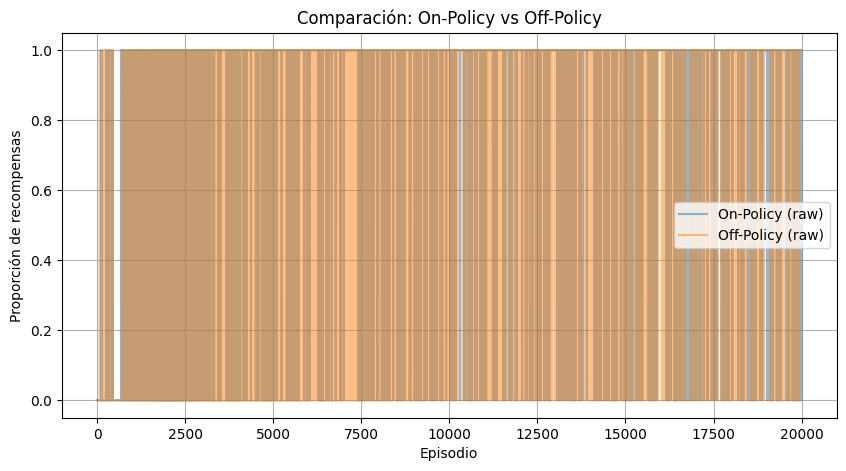

In [59]:
plot_comparison(rewards_per_episode_sarsa_sg, rewards_per_episode_dqn, True)

En la siguiente gráfica podemos observar una comparación de la duración de los episodios y, como podemos observar, SARSA semi-gradiente tiene un promedio bastante menor que DQN, lo que nos indica que aunque en términos de conseguir resolver el problema ambos son similares, SARSA semi-gradiente consigue una política mejor que le permite resolver el problema en menos pasos, aumentando la eficiencia.


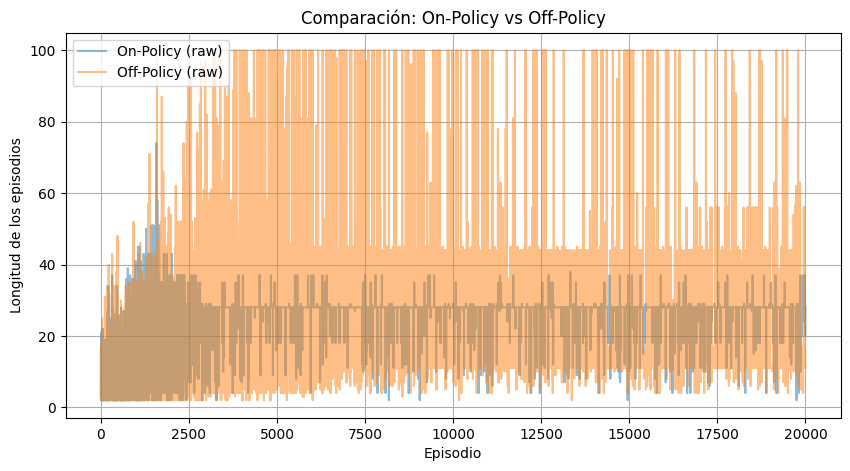

In [60]:
plot_comparison(episodes_sizes_sarsa_sg, episodes_sizes_dqn, False)

A modo de conclusión debemos comentar que los métodos de Monte Carlo son los ganadores indiscutibles en términos de eficiencia. Aunque todos los modelos logran converger, Monte Carlo es el que necesita menos tiempo para ello y además resuelve el problema en el menor número de pasos. En contraposición con el ejercicio de Taxi, donde la distribución de recompensas era continua, la representación discreta de las recompensas en Frozen Lake permite a Monte Carlo converger mejor, mientras que los modelos más complejos tienen problemas para encontrar una política óptima. La falta de feedback representado mediante recompensas para este entorno hace que los modelos más sencillos se desenvuelvan mejor que aquellos que son más complejos.